# pya - Python Audio Coding Package Examples
(c) 2019 by Thomas Hermann, Jiajun Yang and Alexander Neumann, Bielefeld University, Bielefeld, Germany

In [1]:
# This part only makes sure that the repository version of pya is used for this notebook ...
import os, sys, inspect, io

cmd_folder = os.path.realpath(
    os.path.dirname(
        os.path.abspath(os.path.split(inspect.getfile( inspect.currentframe() ))[0])))

if cmd_folder not in sys.path:
    sys.path.insert(0, cmd_folder)

# ... the part relevant for pya usage starts here
from pya import *

In [2]:
# This will chose the most appropriate backend. If you run this notebook locally, this will be PyAudio.
# If you are using Binder, WebAudio will be chosen.
auto_backend = determine_backend()

In [3]:
# Boot up the audio server
# Aserver(sr=44100, bs=256, device=None, channels=2, backend=None, format=pyaudio.paFloat32)
# By default pya will try to use PyAudio as the audio backend
# If buffer size is not passed it will be determined by the backend
s = Aserver(backend=auto_backend)  
Aserver.default = s  # set default Aserver to use play() w/o explicit arg
s.boot()

AServer: sr: 44100, blocksize: 256,
         Stream Active: True, Device: Built-in Output, Index: 1

In [4]:
# To check all available devices 
device_info()

idx Device Name              INP OUT    SR   INP-(Lo|Hi)  OUT-(Lo/Hi) (Latency in ms)
0   Built-in Microphone        2   0 44100    2.9     13    10    100
1   Built-in Output            0   2 44100     10    100   3.9     14


In [5]:
# header - imports
import time
import numpy as np
import scipy
import matplotlib.pyplot as plt
from ipywidgets import interact, fixed, widgets
# plot graphs right into the notebook
%matplotlib inline  
# for dedicated GUI windows with Qt5, uncomment the following line:
# %matplotlib qt5  

## pya - Basics

**Motivation / Purpose**
* pya shall simplify creation, access, processing, analysis and output of multi-channel audio signals
* Signals are regarded as time series sampled at a constant sampling rate (sr)
    * Thus, pya can also work nicely with non-audio time series such as ECG, EEG, EMG, seismography, etc.
* In pya, signals are stored and manipulated as numpy arrays, using scipy functions where possible
    * a direct access to the numpy ndarray is open, promoting direct use if a special pya function should be lacking
    * later version may shield access to the Asigs sig via a property, allowing to deal more consistently with 1-channel audio signals
* For visualization, currently matplotlib is used as default engine
    * later versions may introduce a pyA class variable to select the vis backend (bokeh, mpl, etc.)
* pya may grow into a more interactive tool for audio manipulation
    * using jupyter interact widgets (or others) to control parameters graphically 
    * or to allow interactive selection events and give annotations via a GUI. 
    * However, the core should remain usable as plain python import 
* pya is at this time mainly built for non-realtime signal processing.
    * there is no thread to apply operations blockwise in a processing pipeline and output results in r/t
    * however, a Aserver is available to schedule signal playback at a given onset on a given channel
    * it has to be seen what the best way is to incorporate such features later if needed

**Main Classes**
* Asig - the audio signal class
    * Ugen - a subclass of Asig, unit generator: sine, square, swatooth, noise
* Aserver - the audio server class for playing Asigs
* Aspec - the audio spectrum class, using rfft as real-valued signals are always implied
* Astft - the audio STFT (short-term Fourier transform) class

**Chainable Signal modifications**
* The usual way to create a signal is via the Asig constructor
* Each class includes methods to convert between representations
    * Asig.to_spec --> Aspec
    * Asig.to_stft --> Astft
    * Aspec.to_sig --> Asig
    * Astft.to_sig --> Asig
* methods can be chained to quickly enable complex manipulations. For instance
            myasig[{1.0:1.5}].norm(db=-6).fade_in(0.1).fade_out(0.3)
            .resample(16000).plot(lw=0.2).play(rate=0.2,onset=2.5)
    * the above selects 0.5s starting at 1s, normalizes to -6dB, applies a fade(in/out), 
        resamples, plots and plays signal at yet another rate in 2.5s in one line of code

**Return value access**
* most methods return a new instance of Asig or simply self if there are no changes to any variable. 
* some methods create additional data, e.g. mysignal.find_events() can be used for onset detection and creates a list of events' start and end indices.
* in pya, instead the member variables '_' is initialized as dictionary {}, and used to store custom data, so that they remain associated with the instance.
    * `mysignal._` returns the full dictionary
    * `mysignal._['events']` returns a 2D numpy array of the events

**getitem and setitem**
* pya offers numpy style getitem and setitem access and slicing, e.g asig[start:end], yet it offers more flexibility particular for audio arrangement such as 
    * multi-channel assignment
    * time based subsetting: myasig[{t0:t1},3:] gives an asig that cuts a time slice from t0 to t1, at the same time selecting only channels 3,4... 
* more details can be found in Section 1.2.3

## Asig Audio Signal class

In [6]:
# help(Asig)  # uncomment to see details

### Creating Audio Signals as Asig instances

* An Asig(sig, sr, label) can be created by passing as sig
    * (1) a numpy ndarray,
        * the fast index is for time, the slow index for channels
        * sr=44100 is the default sampling rate in Hz, if no other value is given
    * (2) a filename,
        * the file is loaded via scipy.io.loadwav, 
        * converted to float64 within [-1,1] without normalization, 
        * sampling rate sr is taken from the file. 
        * Multi-channel audio is supported.
    * (3) an integer
        * an empty (zero) signal with the given number of samples is created
    * (4) a float
        * an empty (zero) signal of given duration is created

* the \_\_repr\_\_() reports basic channels x samples @ sampling_rate = duration

In [7]:
asnap = Asig("samples/snap.wav", label='snap')
asnap

Asig('snap'): 1 x 41216 @ 44100Hz = 0.935s cn=['0']

In [8]:
asnap.play()

Asig('snap'): 1 x 41216 @ 44100Hz = 0.935s cn=['0']

mp3 files are supported but required C library ffmpeg, for installation guide refer to [Github](https://github.com/interactive-sonification/pya)

In [9]:
aping = Asig("samples/ping.mp3", label='ping')
aping

Asig('ping'): 1 x 34158 @ 44100Hz = 0.775s cn=['0']

In [10]:
aping.play()

Asig('ping'): 1 x 34158 @ 44100Hz = 0.775s cn=['0']

In [11]:
# load a speech sample
aword = Asig("samples/sonification.wav", label='word')
aword

Asig('word'): 1 x 87040 @ 44100Hz = 1.974s cn=['0']

In [12]:
aword.play()

Asig('word'): 1 x 87040 @ 44100Hz = 1.974s cn=['0']

In [13]:
# create a signal from data
anoise = Asig(np.random.randn(44100), sr=44100, label='noise')
anoise

Asig('noise'): 1 x 44100 @ 44100Hz = 1.000s cn=['0']

In [14]:
# record() helper function is currently removed until future release. 
# Use Arecorder() for recording. 
# # record an audio signal, follow with a normalization
# arec = Asig(record(2.0), label='rec').norm()

In [15]:
# create 2s silence at default sr
Asig(2.0, label='sonification')

Asig('sonification'): 1 x 88200 @ 44100Hz = 2.000s cn=['0']

In [16]:
# create a 44100 x 4 signal at 22050 sr, give the channel names cn 
asignal = Asig(44100, sr=44100//2, label='silence', channels=4, cn=['a', 'b', 'c', 'd'])

**Useful Aisg attributes**

In [17]:
asignal.sig       # signal array 

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]], dtype=float32)

In [18]:
asignal.samples   # nr of samples on each channels

44100

In [19]:
asignal.channels  # nr of channels

4

In [20]:
asignal.sr        # sampling rate

22050

In [21]:
asignal.label     # asig label 

'silence'

In [22]:
asignal.cn        # channel name list

['a', 'b', 'c', 'd']

**Unit generator**

* Ugen().sine(freq=440, amp=1.0, dur=1.0, sr=44100, channels=1, cn=None, label="sine")
* Ugen().square(freq=440, amp=1.0, dur=1.0, duty=0.4, sr=44100, channels=1, cn=None, label="square")
* Ugen().sawtooth(freq=440, amp=1.0, dur=1.0, width=1., sr=44100, channels=1, cn=None, label="sawtooth")
* Ugen().noise(type="white", amp=1.0, dur=1.0, sr=44100, channels=1, cn=None, label="noise")  # type = white or pink

In [23]:
asine = Ugen().sine(freq=200, sr=1000, channels=4)  # create a 4-channel sine
asine

Asig('sine'): 4 x 1000 @ 1000Hz = 1.000s cn=['0', '1', '2', '3']

### Plot and play Asigs

* play(rate=1, **kwargs) plays the signal via the given server.
  It allows to control the rate
    * 1=original rate, 2=twice as fast, 0.5=half time
    * internally the signal is resampled before sending to audio output
    * indicate which Aserver for playback, defaults to Aserver.default, if set
    * onset=value allows to specify when sound shall be played
        * as relative time to *now* if using a float <1e6
        * as absolute time (e.g. use time.time()+value)
    * block=True causes a time.sleep() for the play duration after
      queueing the sound, but only if onset is not set
* play returns self 

In [24]:
asnap.play(0.2)  # try with 0.5, 0.1

Asig('snap'): 1 x 41216 @ 44100Hz = 0.935s cn=['0']

In [25]:
aword.play(0.7)  # try with 0.5, 0.1

Asig('word'): 1 x 87040 @ 44100Hz = 1.974s cn=['0']

In [26]:
(asnap * 0.5).play()  # direct gain control

Asig('snap_multiplied'): 1 x 41216 @ 44100Hz = 0.935s cn=['0']

In [27]:
asnap.gain(db=-22).play()  # very quiet snap, dB attentuation

Asig('snap_scaled'): 1 x 41216 @ 44100Hz = 0.935s cn=['0']

Since asig plays in a non-blocking way, to play 2 sounds together 
you can simple play one after another.

In [28]:
asnap.play()
aword.play()

Asig('word'): 1 x 87040 @ 44100Hz = 1.974s cn=['0']

Alternatively, you can mix two signals together bying adding them. Using x or extend property
* This will result in a size based on the longer one.

In [29]:
print("Length in second: ", asnap.get_duration(), aword.get_duration())
try:
    (asnap + aword).play() 
except ValueError:
    print("asnap and aword are different in size")

(asnap.x + aword).play()  # same as (asnap.extend + aword).play() 


Length in second:  0.9346031746031747 1.9736961451247166
asnap and aword are different in size


Asig('snap_added'): 1 x 87040 @ 44100Hz = 1.974s cn=['0']

Or you can use b or bound to limit the result based on the shorter one

In [30]:
(asnap.b + aword).play()  # same as (aword.b + asnap).play()

Asig('snap_added'): 1 x 41216 @ 44100Hz = 0.935s cn=['0']

use onset=value to control the playback time

In [31]:
import time
t0 = time.time()
asnap.play(onset=t0+0.75)
aword.play(onset=t0+0.1)

Asig('word'): 1 x 87040 @ 44100Hz = 1.974s cn=['0']

In [32]:
# using relative time stamps (less precise)
aword.play(onset=0.1)
asnap.play(onset=0.75)

Asig('snap'): 1 x 41216 @ 44100Hz = 0.935s cn=['0']

* plot(fn=None, **kwargs):
    * fn either accepts a string e.g. 'db' for decibel plotting
        * this assumes 16bit=96dB for full signal
    * or fn can be a function for custom warping
* plot plots the signal using matplotlib
    * return value is the lines
    * kwargs are propagated to the plot()
* plot returns self but sets the 'plot' key in dict _ with the matplotlib.lines.Line2D 

Asig('word'): 1 x 87040 @ 44100Hz = 1.974s cn=['0']

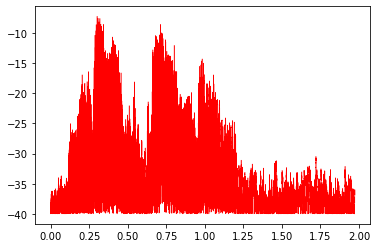

In [33]:
aword.plot(lambda x: ampdb(abs(x)+0.01), lw=0.5, color="r")  # try also with arg 'db'

Asig('word'): 1 x 87040 @ 44100Hz = 1.974s cn=['0']

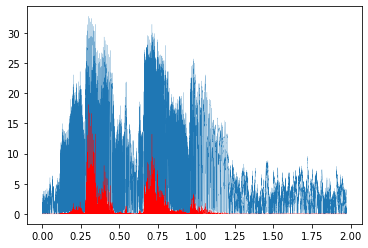

In [34]:
aword.plot(lambda x: ampdb(abs(x)*1e2+1), lw=0.15)
aword.plot(lambda x: 100*abs(x)**2, color='red', lw=0.25)

In [35]:
aword.play(0.2)  # this takes a long time but returns immediately

Asig('word'): 1 x 87040 @ 44100Hz = 1.974s cn=['0']

In [36]:
s.stop()  # stop the sound bying stopping the server. This will erase the server buffer

In [37]:
aword.play(1.)

Asig('word'): 1 x 87040 @ 44100Hz = 1.974s cn=['0']

{'plot': [<matplotlib.lines.Line2D at 0x11f1e9748>]}

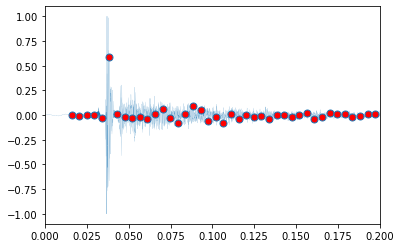

In [38]:
# demonstrate plot() and play() daisy-chained and subsequent access to the _ dict
asnap.plot(marker='o', mfc='r', ms=7, lw=0.1).play(server=s)._['plot'][0].set_markevery((700, 200))
plt.xlim(0, 0.2);
asnap._

### Accessing items, slicing and time slicing 

* The signal is stored in the attribute self.sig
* you can read and assign to that attribute directly
    * note that by doing so you are responsible for keeping 
        self.sr and self.samples valid
* slicing works just as with arrays, sample-accurate

Asig('sine_fadein_fadeout_multiplied_normalised'): 1 x 600 @ 1000Hz = 0.600s cn=['0']

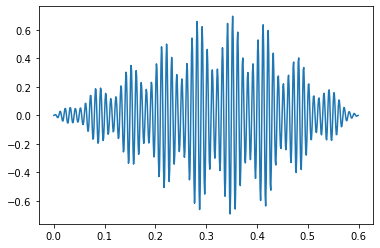

In [39]:
b = Ugen().sine(freq=100, sr=1000, dur=0.6).fade_in(0.3).fade_out(0.2)
b *= 0.5+0.2*np.sin(2*np.pi*15*b.get_times())  # AM, note that you can directly apply arithemetics to Asig rather than Asig.sig
b.plot().norm().play()
# note that repeated cell executions changes signal more and more

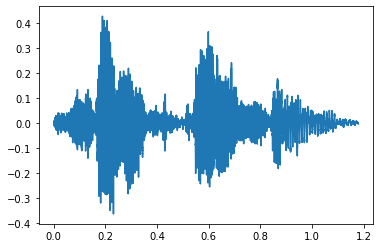

In [40]:
b = aword[5000:57000].plot()

* use full slice [start:stop:stride] to downsample or reverse signal

In [41]:
aword[-1:0:-1].play()  # reversed word via -1 step in slice

Asig('word_arrayindexed'): 1 x 87039 @ 44100Hz = 1.974s cn=['0']

In [42]:
def test_stride(stride=2):
    aword[0:40000:stride].play()
interact(test_stride, stride=(1,20,1));

interactive(children=(IntSlider(value=2, description='stride', max=20, min=1), Output()), _dom_classes=('widge…

* All types of slicing:
    * int: subset a single value or row
    * slice
    * integer list for the row: subset rows
    * string list for the column: subset based on channel names **cn**
    * dict: time slicing in seconds

**Multi-Channel selection**

In [43]:
# create a 4-channel sine
amultichan = Ugen().sine(freq=200, sr=2000, channels=4, cn=['a','b','c','d'])  

# create a 1-channel sawtooth
amono = Ugen().sawtooth(freq=40, sr=2000, channels=1)  

In [44]:
# use index list to create a subset of samples
amono[[3, 30, 300]].sig 
amultichan[[3, 30, 300], :].sig 

array([[0.9507647 , 0.9507647 , 0.9507647 , 0.9507647 ],
       [0.00942935, 0.00942935, 0.00942935, 0.00942935],
       [0.09415525, 0.09415525, 0.09415525, 0.09415525]], dtype=float32)

In [45]:
# channel selection based on channel name cn, using a list
amultichan[:, ['a']]
amultichan[:, ['a', 'd']]

Asig('sine_arrayindexed'): 2 x 2000 @ 2000Hz = 1.000s cn=['a', 'd']

In [46]:
amultichan[:, [False, False, True, False]]  # subset channel using bool list

Asig('sine_arrayindexed'): 1 x 2000 @ 2000Hz = 1.000s cn=['c']

In [47]:
# You can use a dictionary for time slicing. {start:end}
amultichan[{0.2:0.6}]   # from 0.2 to 0.6 second
amono[{0.2:-0.4}]       # This results the same as above, start at 0.2, end at 0.4 to the end.  

Asig('sawtooth_arrayindexed'): 1 x 800 @ 2000Hz = 0.400s cn=['0']

In [48]:
amultichan[0:amultichan.samples:4, ['a', 'c']]    # a rough down-sampling

Asig('sine_arrayindexed'): 2 x 500 @ 500Hz = 1.000s cn=['a', 'c']

### `__setitem__`, and advanced `__setitem__`

The previous section demonstrate various ways of indexing signals. This section demonstrates how to modify a signals subset using the `__setitem__`. 

Since audio signals often have different sizes (i.e. lengths), we implemented several advanced setitem methods to enable more flexible assignment options as dimensions on left and right side differ. In `adest[selection1] = asrc[selection2]` we refer to the right side as 'source' and the left side as 'destination'.

* bound ('b'): truncates source so that it fits into the destination 
* extend ('e'): automatically extends destination if source would extend beyond end 
* overwrite ('o'): 

Practically, the modes are implemented as properties that are set using a method so that subsequent slicing respects the choice. At the end the mode is resetted.

Let's start with some test signals to demo the setitem modes:

In [49]:
# create some test signals 
amultichan = Ugen().sine(freq=200, sr=2000, channels=4, cn=['a','b','c','d'])  # create a 4-channel sine
amono = Ugen().sawtooth(freq=40, sr=2000, channels=1)  # create a 1-channel sawtooth
anoise = Ugen().noise(sr=2000, channels=1)  # create a 1-channel white noise

The following three lines demonstrate classical, python standard, resp. numpy standard compatible assignment:

In [50]:
amono[3:6] = [1.0, -1.0, 0.5]  # set three samples explicitly with values
amono[20:40] = np.zeros(20)    # set 20 samples to zero
amono[{0.5: 0.7}] = anoise[{0.2: 0.4}]  # set a 200ms-segment to noise, requiring length match

**bound mode**

if the new array would be out of bounds given the source array, the bound mode truncates source to fit into the destination.

* usage: 
    * `asig.bound[slice] = new_signal`
    * `asig.b[slice] = new_signal`     (shortcut)

* Note that b is implemented as property so that brackets '()' can be foregone and the syntax is kept lean.

In [51]:
try:
    amono[-10:] = np.ones(20)  # This won't not work and raise the exception
except ValueError:
    amono.b[-10:] = np.arange(20)  # The first 10 elements will be assigned. 
amono[-10:].sig

array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.], dtype=float32)

**extend mode** 

if the new array would be too long to fit in the destination, the extend mode will automatically extend the destination asig as needed.

* usage:
    * `asig.extend[slice] = new_signal`
    * `asig.x[slice] = new_signal`  (shortcut)
* Note that x is implemented as @property, so that brackets `()` can be foregone
* Note that this is useful for sequencing multiple audio signals 

Asig('x-demosig'): 4 x 2200 @ 1000Hz = 2.200s cn=['a', 'b', 'c', 'd']

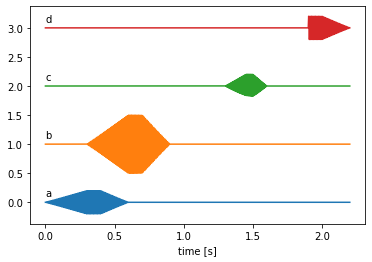

In [52]:
a = Asig(0.8, sr=1000, channels=4, cn=['a', 'b', 'c', 'd'], label='x-demosig')
b = Ugen().sine(freq=100, sr=1000, dur=0.6).fade_in(0.3).fade_out(0.2)
a.x[:, 'a'] = 0.2 * b  # no need to extend as len(src)<len(dest) 
a.x[300:, 'b'] = 0.5 * b  # extends a to 0.9 seconds
a.x[1300:, 'c'] = 0.2 * b[::2]  # extends a further, writing beyond end in the first place
a.x[1900:, 3] = 0.2 * b[300:]  # note that 3 is 'd' as channel indexing starts with 0
a.plot(offset=1)

**overwrite mode** 

if the source and destinations have different lengths, overwrite mode 
* cuts the destination out
* and insert the source, 
* i.e. it replaces the destination subset with another one of possibly different length

*usage
    * `asig.overwrite[slice] = new_signal`
    * `asig.o[slice] = new_signal` (shortcut syntax)
    
* Note that this is useful for inserting audio segments into an existing signal
* Note that, although you can insert an asig with a different sampling rate, overwrite only treats it as a numpy array and does not resample the source to fit to the destination.

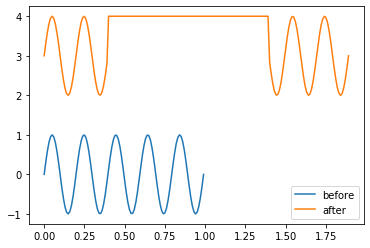

In [53]:
a = Ugen().sine(freq=5, sr=100, dur=1.0)
a.plot(label="before")

b = Asig(np.ones(100))
a.o[40:50] = b  # here the overwrite example!

(a+3).plot(label="after")  # offset by 3 for nicer plot
plt.legend();

### Normalize signal amplitude and set gain

* norm(norm=1, dcflag) allows to normalize the signal 
    * to an extreme value given by norm>0
    * negative values for norm are interpreted as level in dB
* set dcflag=True to first remove DC bias.

In [54]:
for n in [1, 0.5, 0.1, -6, -12, -18, -24, -30, -36, -42]:
    asnap[{0.1:0.4}].norm(n).gain(db=-30).play(block=True)

* remove_DC() removes the DC offset channelwise
    * this is equivalent to `asig - asig.sig.mean(axis=0)`

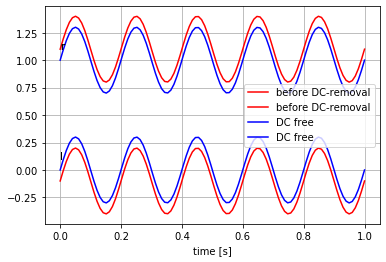

In [55]:
atest = (Ugen().sine(freq=5, sr=100, dur=1.0)*0.3).stereo() + [-0.1, 0.1]
atest.plot(offset=1, color='r', label='before DC-removal')
atest.remove_DC().plot(offset=1, color='b',label='DC free')
plt.legend(); plt.grid()

* apply gain(amp=None, db=None) to returns an amplified signal
    * db overwrites amp, so use as follows

In [56]:
# increase level by 20 db
asnap[{0.3: 0.5}].gain(db=20).play()

Asig('snap_arrayindexed_scaled'): 1 x 8820 @ 44100Hz = 0.200s cn=['0']

In [57]:
# multiply signal with 42
asnap[{0.3: 0.5}].gain(42).play()

Asig('snap_arrayindexed_scaled'): 1 x 8820 @ 44100Hz = 0.200s cn=['0']

### Fading in and out, and arbitrary envelopes

The methods 
* fade_in(dur=0.1, curve=1) and
* fade_out(dur=0.1, curve=1)

allow to apply a polynomial fading at begin (_in) or end (_out)
* curve is the exponent to the line from 0 to 1, i.e. 
    * curve=2 is a parabolic curve, etc...
    * curve=0.5 is a sqrt curve, etc...

Asig('noise_fadein_fadeout_normalised'): 1 x 10000 @ 10000Hz = 1.000s cn=['0']

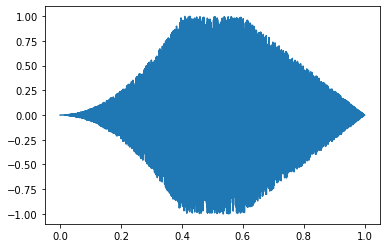

In [58]:
anoise = Ugen().noise(sr=10000, channels=1)  # create a 1-channel white noise

b = anoise.fade_in(0.4, curve=2).fade_out(0.4, curve=1) # try 1,2,3, 0.5, 0.33, 0.25
b.norm().plot().play(onset=0.5)

In [59]:
anoise.fade_out(0.95, curve=8).play() # fake snare drum

Asig('noise_fadeout'): 1 x 10000 @ 10000Hz = 1.000s cn=['0']

**envelope(amps, ts=None, curve=1, kind='linear')** 

applies arbitrary linear envelopes:

* `amps` is list or array of amplitude gains
* if `ts` is set, it needs to be the corresponding times for values in `amps`
* `curve` (as of now) is a polynomial exponent, similar to the fade parameter
* `kind` is either `'linear'` or `'exp'` (TODO: not yet implemented)

Asig('noise_enveloped'): 1 x 10000 @ 10000Hz = 1.000s cn=['0']

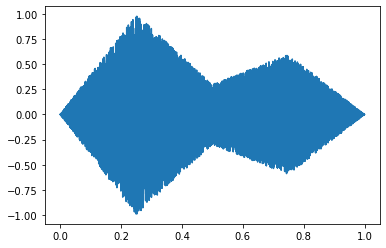

In [60]:
anoise.envelope([0, 1, 0.3, 0.6, 0]).plot()

Asig('noise_enveloped'): 1 x 10000 @ 10000Hz = 1.000s cn=['0']

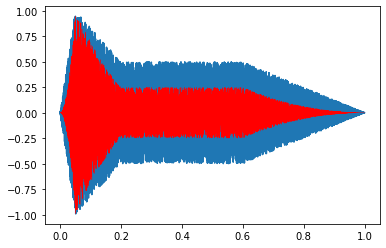

In [61]:
anoise.envelope([0, 1, 0.5, 0.5, 0], [0, 0.05, 0.2, 0.6, 1]).plot() # adsr
anoise.adsr(0.05, 0.15, 0.5, 0.4, curve=2).plot(color='r', lw=0.4)

### Resample

**resample(self, target_sr=44100, rate=1, kind='quadratic')**:

resample signal to given sampling rate `target_sr`
* at the same time the playback rate can be modified
    * rate 0.5 (resp. 2) is half (resp. twice) the speed
* use kind to control the kind of interpolation
    * valid are those accepted by scipy.interpolate.interp1d, 
    * ('linear', 'nearest', 'zero', 'slinear', 'quadratic', 'cubic', 'previous', 'next')
    * An integer specifies the order of the spline interpolator to use.
    * samples are seen as time points at which a new reading is taken
        * i.e. the left side of a rectangle in a sample and hold plot
* **Warning**: this is not band-limited. Aliasing will occur when downsampling

In [62]:
print(asnap)
asnap.resample(16000)   # resample signal at sampling rate

Asig('snap'): 1 x 41216 @ 44100Hz = 0.935s cn=['0']


Asig('snap_resampled'): 1 x 14953 @ 16000Hz = 0.935s cn=['0']

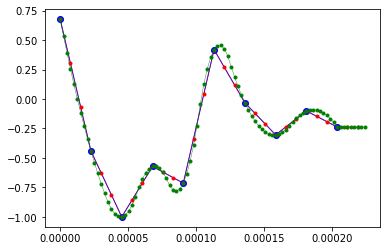

In [63]:
a = asnap[1630:1640].plot(marker='o', lw=1, color='b', markersize=6)
a.resample(3*a.sr, kind='linear').plot(marker='.', lw=0.4, color='r')
a.resample(9*a.sr, rate=1, kind=2).plot(marker='.', lw=0.4, color='g');

### RMS

`rms(axis=0)` returns the root-mean-square of the signal

* no window is used
* use `axis=1` to compute the rms samplewise over channels
* can be used with `window_op()` (see below) to estimate the amplitude envelope of a signal

In [64]:
asnap.rms(axis=0)

0.032927915

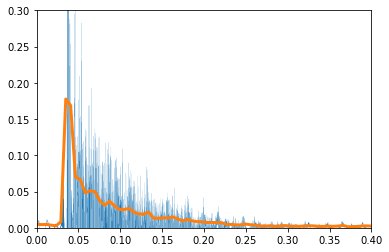

In [65]:
# here rms is used in window_op to compute stepwise signal energy, see window_op() below
asnap.plot(lw=0.1)
asnap.window_op(nperseg=512, stride=256, win='cosine', fn='rms', pad='mirror').plot(lw=3)
plt.axis([0,0.4, 0, 0.3]);

### get_duration, get_times

`get_duration()` 
* returns the duration of the signal in seconds, 
* which is computed as self.samples/self.sr

In [66]:
asnap.get_duration()

0.9346031746031747

`get_times()` 
* returns the array of timestamps for all samples, 
* i.e. `linspace(0, self.samples-1, self.samples)`

In [67]:
Asig([0, 1, 0, 1, 0, 1, 0, 1, 0.5, 0], sr=10).resample(20).get_times()  
# try  other resampling rates, e.g. 5, 10, 20, 40

array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95])

### add

`as1.add(sig, pos=None, amp=1, onset=None)`

* linearly superimposes signal `sig` (multiplied with `amp`) on signal as1,
* starting at position `pos`
* a given `onset` trumps `pos`

In [68]:
aevent = Ugen().sine(freq=250, dur=0.2, label='event').fade_out(0.2, 2).play()

Asig('mix_normalised'): 1 x 88200 @ 44100Hz = 2.000s cn=['0']

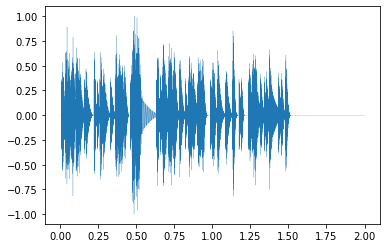

In [69]:
as1 = Asig(2.0, label='mix')  # the canvas
for _ in range(100):
    as1.add(aevent.resample(rate=6+2*np.random.randn()), onset=1.5*np.random.random())
as1.norm().plot(lw=0.2).play(onset=1)

### window

`window(win='triang', **kwargs)`

* applies a window function to the signal 
* the win argument and optional subsequent kwargs are forwarded to `scipy.signal.get_window()`, see documentation there
* available functions are:
    * boxcar, triang, blackman, hamming, hann, bartlett, flattop, parzen, bohman, blackmanharris, nuttall, barthann, kaiser (needs beta), gaussian (needs standard deviation), general_gaussian (needs power, width), slepian (needs width), dpss (needs normalized half-bandwidth), chebwin (needs attenuation), exponential (needs decay scale), tukey (needs taper fraction)
* if parameters are needed, use a tuple instead of a string as first argument

Asig('noise_gaussian_scaled'): 1 x 10000 @ 10000Hz = 1.000s cn=['0']

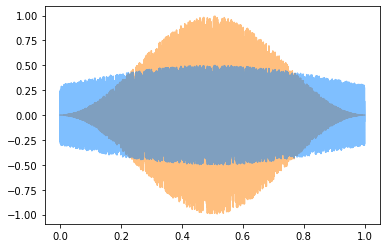

In [70]:
anoise.window('hann').plot(color=(1,0.5,0,0.5))
anoise.window(('gaussian', 5000)).gain(db=-6).plot(color=(0,0.5,1,0.5))

### iirfilter

`iirfilter(cutoff_freqs, btype='bandpass', ftype='butter', order=4, filter='lfilter', rp=None, rs=None)`

filters the signal with an iirfilter 
* of given `ftype` = ‘butter’, ‘cheby1’, ‘cheby2’, ‘ellip’, ‘bessel’
* of given `btype` = 'bandpass', 'bandstop', 'lowpass', 'highpass'
* of given `order` (integer value)
* filtering with given filter method 
    * default: 'lfilter', but use 'filtfilt' for forward-backword filtering
* Note that some filters require maximum ripple dB in rp and minimum passband attenuation dB in rs
* returns filtered signal as new signal, setting the `_` dict keys 'a' and 'b' with filter coefficients

{'b': array([ 0.00012376,  0.        , -0.00049502,  0.        ,  0.00074254,
         0.        , -0.00049502,  0.        ,  0.00012376]),
 'a': array([  1.        ,  -7.30694126,  23.46766316, -43.27178945,
         50.10425429, -37.30726119,  17.44517038,  -4.68400611,
          0.55291062])}

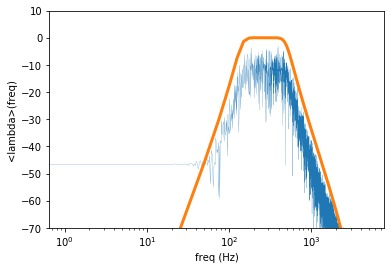

In [71]:
af = anoise.iirfilter([140, 500], order=4, btype='bandpass', filter='lfilter')
afs = af.to_spec().plot(lambda x: ampdb(x)-46, lw=0.2)  # why -46?
af.plot_freqz(200, lw=3)
plt.ylim(-70,10)
plt.semilogx()  # comment out to see linear frequency
af._

### window_op

`window_op(nperseg=64, stride=32, win=None, fn='rms', pad='mirror')`

performs a windowed operation on the signal
* using chunks of `nperseg` samples
* selected at stride `stride`
* applying window `win` to the chunk (any `scipy.signal.window` is possible)
* and subjecting that signal to the function `fn` (default 'rms')
* TODO: implement proper padding, currently the first window starts at 0, i.e. not centered at 0...

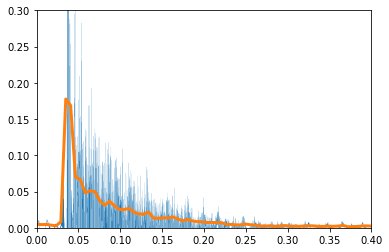

In [72]:
# here rms is used in window_op to compute stepwise signal energy, see window_op() below
asnap.plot(lw=0.1)
asnap.window_op(nperseg=512, stride=256, win='cosine', fn='rms', pad='mirror').plot(lw=3)
plt.axis([0,0.4, 0, 0.3]);

Asig('window_oped_scaled'): 1 x 43520 @ 22050Hz = 1.974s cn=['0']

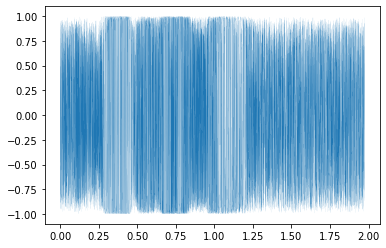

In [73]:
import scipy
# local linear correlation coefficints as signal 
# - signal statistics audification in 3 line of code
def lk(a):
    return scipy.stats.pearsonr(a.sig, np.arange(a.sig.shape[0]))[0]
aword.window_op(8, 2, None, fn=lk).plot(lw=0.05).gain(0.3).play(onset=2)

### Overlap and add demo

`overlap_add(nperseg=64, stride_in=32, stride_out=32, win=None, pad='mirror')`

cuts the signal in chunks of lengths `nperseg`

* starting at sample 0 with stride `stride_in`
* applying a window `win` to the chunks
* and adding them together into an empty signal at stride `stride_out`
* choosing different `stride_in` and `stride_out` results in granular time stretching 
* TODO: padding needs to be implemented...

In [74]:
atest = aword
def ola_demo(begin=0.0, end=2.0, nperseg=128, stride_in=64, jitter_in=0, 
             stride_out=64, jitter_out=0):
    b = atest[{begin: end}].overlap_add(nperseg, stride_in, stride_out, 
                    jitter_in=jitter_in, jitter_out=jitter_out, win='triang')
    b.plot().norm(0.2).play()
interact(ola_demo, nperseg=(64,1024,32), 
         stride_in=(2, 512, 1), jitter_in=(0,200,10), 
         stride_out=(2,512,1), jitter_out=(0,200,10));

interactive(children=(FloatSlider(value=0.0, description='begin', max=1.0), FloatSlider(value=2.0, description…

### find_events

`find_events(self, step_dur=0.001, sil_thr=-20, sil_min_dur=0.1, sil_pad=[0.001,0.1])`

detects events separated by silence
* criterion for event start is signal to exceed the silence threshold `sil_thr` (in dB)
* ending after sub-threshold signal of at least `sil_min_dur` seconds is observed
* the resulting event is then padded with signal left and right given by `sil_pad` (in seconds)
* `find_events()` returns self, but sets its results into dict self._ in key 'events'
    * which is a ndarray with column 1 all event_start_sample and event_stop_sample in columns

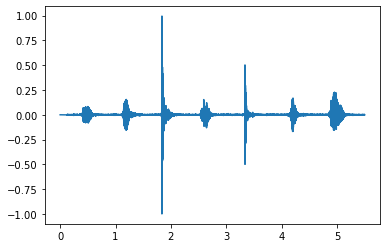

In [75]:
aa = Asig("samples/vocal_sequence.wav").plot() #.play()
# or record your own...
# arec = Asig(record(6.0), label='rec').norm()

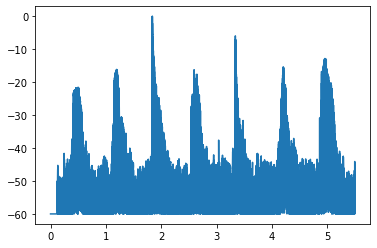

In [76]:
aa.plot(lambda x: ampdb(abs(x)+1e-3));
# obviously events exceed -35 dB, and noise is below that level

In [77]:
import time

In [78]:
aa.find_events(step_dur=0.001, sil_thr=-35, sil_min_dur=0.1, sil_pad=[0.001,0.05])
aa._['events']

array([[ 18084,  27109],
       [ 50336,  58701],
       [ 80872,  89941],
       [111936, 120917],
       [147092, 151717],
       [183612, 190745],
       [215116, 228277]])

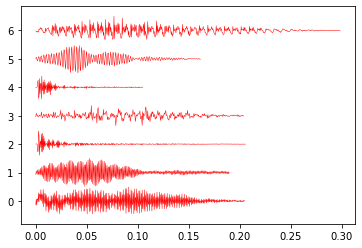

In [79]:
# play and plot all events
for i, (a,e) in enumerate(aa._['events']):
    aa[a:e].norm().play(onset=0.2+0.2*i)[::20].plot(lambda x: i+0.5*x, lw=0.5, color='r')

In [80]:
# show all event onsets
aa._['events'][:,0]

array([ 18084,  50336,  80872, 111936, 147092, 183612, 215116])

### select_event

`select_event(index=None, onset=None)`

allows to easily select an event in an audio file

* it uses the _['events'] entry as set either manually or via the previous `find_events()` method
* `index` specifies the number in the list, starting with 0
* the event is sliced from the signal using the begin and end samples
* a given `onset` trumps `index` and selects that event whose begin is closest to the given onset
    * TODO: preferred: the event in which the onset lies should be preferred to the nearest begin...

Asig('event_4_normalised'): 1 x 4625 @ 44100Hz = 0.105s cn=['0']

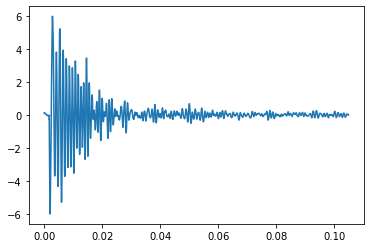

In [81]:
aa.select_event(4).norm(-6).plot().play(0.8)

Asig('event_6'): 1 x 13161 @ 44100Hz = 0.298s cn=['0']

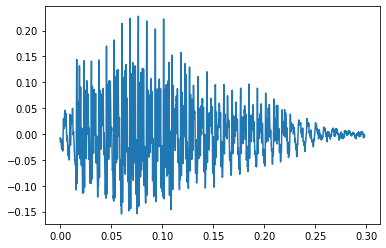

In [82]:
aa.select_event(onset=5.2).plot().play()

### plot_spectrum

Asig('snap'): 1 x 41216 @ 44100Hz = 0.935s cn=['0']

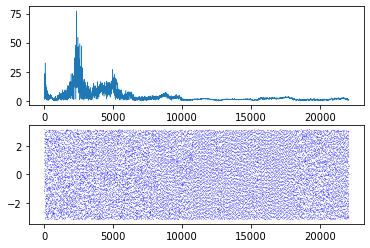

In [83]:
asnap = Asig("samples/snap.wav", label='snap')
asnap.plot_spectrum(lw=0.5)  #plots spectrum magnitude and phase

### spectrogram

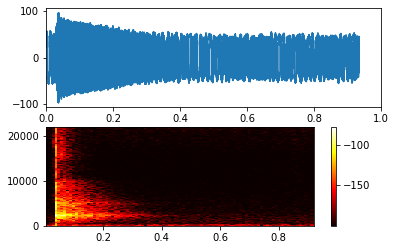

In [84]:
plt.subplot(211); 
a = asnap.norm().plot('db');plt.xlim(0, 1)
freqs, times, S = a.spectrogram(nperseg=512)

plt.subplot(212);
plt.pcolormesh(times, freqs, ampdb(np.abs(S)+1e-10), cmap='hot')
plt.colorbar();

### to_spec

Aspec('word_spec'): 1 x 87040 @ 44100 Hz = 1.974 s

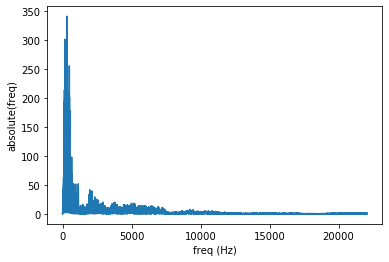

In [85]:
aword = Asig("samples/sonification.wav", label='word')
aword_spec = aword.to_spec()
aword_spec.plot()

### fun stuff...

In [86]:
#.to_spec().weight([0,1,0.3, 0.1], [800, 1200, 5500, 12000]).to_sig() #.norm().play()
# as3[15000::].tslice(0,0.5).norm().fade_in(0.2).fade_out(0.2).to_spec().weight([0, 1,5,1], [4000, 4001, 9000, 13000]).plot() # to_sig().play(0.5)
# gain(amp=1).plot_spectrum()
# as3[0:7000].resample(rate=0.125).norm().fade_in(0.2, curve=2).fade_out(0.1, curve=4).play()

Asig('snap_arrayindexed_resampled_spec_weighted_2sig_normalised_scaled'): 1 x 1632 @ 8000Hz = 0.204s cn=['0']

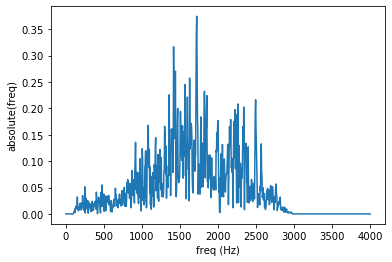

In [87]:
# aa = Asig(np.random.random(10000)-0.5, 8000)
h = asnap[6000:15000].resample(8000).to_spec().weight([0,1,0.2,0], [100, 1510, 1920, 2990], curve=1)
h.plot() # rfftspec
h.to_sig().norm().gain(0.2).play(1)

## Asig synthesis/sonification examples

CPU times: user 118 ms, sys: 19.4 ms, total: 137 ms
Wall time: 150 ms


Asig('window_oped'): 1 x 87 @ 86Hz = 1.012s cn=['0']

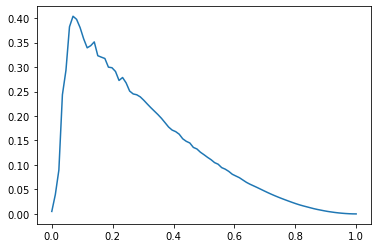

In [88]:
sr = 44100
t = np.linspace(0, 1, sr)
v = np.sin(2*np.pi*101*t**1.5)
si = Asig(v, sr, "chirp").envelope([0,1,0], [0,0.05,1], curve=1.9)
# si.window_op(64, 256, fn=lambda a: np.max(a.sig)).norm(0.9).plot()
%time si[::4].window_op(256, 128, fn='rms', win='bartlett').plot()

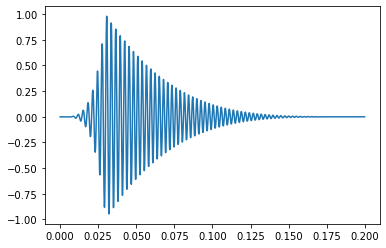

In [89]:
sr = 8000
t = np.linspace(0, 0.4, int(sr*0.2))
v = np.sin(2*np.pi*200*t**1.1)
si = Asig(v, sr, "chirp").fade_in(0.01).envelope([0,1,0], [0,0.03,0.2], curve=4).plot().stereo().play()

In [90]:
son = Asig(np.zeros(5*sr), sr, "sonification")

In [91]:
si.resample(sr, rate=1+2*np.random.random())

Asig('chirp_fadein_enveloped_to_stereo_resampled'): 2 x 763 @ 8000Hz = 0.095s cn=['l', 'r']

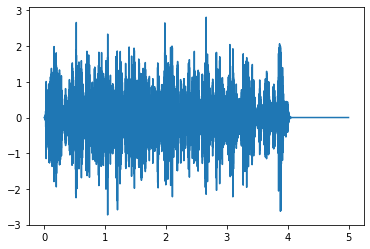

In [92]:
for i in range(500):
    onset = np.random.randint(0, 4000)/1000
    amp = abs((i-250)/250)
    son.add(si.mono().resample(son.sr, rate=1+2*np.random.random()), onset=onset, amp=amp)
son.norm().play()
son.plot();

## Aspec - Audio Spectrum class

Examples / Documentation: TODO

### init

### repr

### plot

### weight

### to_sig

## Astft - Audio STFT class

In [93]:
# araw = Asig(record(3), 44100, 'vocal').norm()
# a = araw[30000:80000].resample(22050)

In [94]:
a.norm().play()

Asig('snap_normalised_normalised'): 1 x 41216 @ 44100Hz = 0.935s cn=['0']

In [95]:
ast = Astft(a, nperseg=64)
ast

Astft('snap_normalised_stft'): 1 x 41216 @ 44100 Hz = 0.935 s cn=['0']

Astft('snap_normalised_stft'): 1 x 41216 @ 44100 Hz = 0.935 s cn=['0']

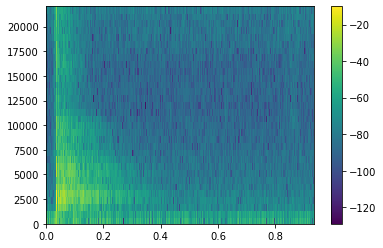

In [96]:
ast.plot(ampdb)

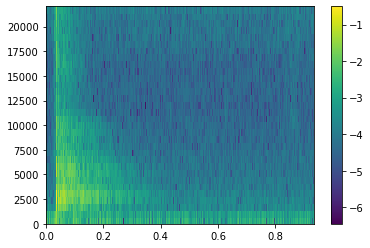

In [97]:
ast.plot(np.log10);

In [98]:
ast.to_sig().norm(0.8).play()

Asig('snap_normalised_stft_2sig_normalised'): 1 x 41216 @ 44100Hz = 0.935s cn=['0']

In [99]:
import copy
ast2 = copy.deepcopy(ast)

## AServer

* AServer is an audio server for coordinating multi-channel audio output via pyaudio / portaudio
    * it provides basic functions to list and select audio interfaces
    * it allows to schedule Asigs for playback at a certain absolute time or relative time difference 
    * and manages the superposition of multichannel signals for threaded computation of the required audio frame blocks for pyaudio.
* Aserver furthermore serves as parent class for Arecorder - which allows stream-based input

In [100]:
# Boot up the audio server
# Aserver(sr=44100, bs=256, device=None, channels=2, format=pyaudio.paFloat32)
s = Aserver(backend=auto_backend)  
Aserver.default = s  # set default Aserver to use play() w/o explicit arg
s.boot()

AServer: sr: 44100, blocksize: 256,
         Stream Active: True, Device: Built-in Output, Index: 1

* get_devices(verbose=True) 
    * prints all input devices and 
    * returns the list of dictionaries with all details

In [101]:
res = s.get_devices(verbose=False)
print(f"{len(res[0])} input and {len(res[1])} output devices")
print(f"=== First input device: \n{res[0][0]}\n")
print(f"=== First output device: \n{res[1][0]}")

1 input and 1 output devices
=== First input device: 
{'index': 0, 'structVersion': 2, 'name': 'Built-in Microphone', 'hostApi': 0, 'maxInputChannels': 2, 'maxOutputChannels': 0, 'defaultLowInputLatency': 0.0029478458049886623, 'defaultLowOutputLatency': 0.01, 'defaultHighInputLatency': 0.01310657596371882, 'defaultHighOutputLatency': 0.1, 'defaultSampleRate': 44100.0}

=== First output device: 
{'index': 1, 'structVersion': 2, 'name': 'Built-in Output', 'hostApi': 0, 'maxInputChannels': 0, 'maxOutputChannels': 2, 'defaultLowInputLatency': 0.01, 'defaultLowOutputLatency': 0.0038775510204081634, 'defaultHighInputLatency': 0.1, 'defaultHighOutputLatency': 0.014036281179138322, 'defaultSampleRate': 44100.0}


In [102]:
device_info()

idx Device Name              INP OUT    SR   INP-(Lo|Hi)  OUT-(Lo/Hi) (Latency in ms)
0   Built-in Microphone        2   0 44100    2.9     13    10    100
1   Built-in Output            0   2 44100     10    100   3.9     14


##  Arecorder - Audio Recorder

Arecorder is a class to establish a pyaudio stream to process audio input data.
* Several Arecorder instances, operating on different audio devices can be used simultaneously

Arecorder provides the following methods (to be extended)
* On `boot()`, the stream is opened and started.
    * On each incoming audio block, the Arecorder-internal callback function _recording_callback() is called.
    * According to recorder state, data is appended to the record_buffer list or ignored
* by `record()`, the recorder starts a new (or continues a paused) recording
* on `pause()`, it pauses and does nothing else
* on `stop()`, the collected data in record_buffer is converted into an Asig, which is appended to recordings

Recordings are stored in Arecorder.recordings, a list of Asigs
* use `recordings.clear()` to reset/empty the list
* use `recordings[-1]` to access the newest recording
* use `recordings.pop()` to get next in FILO manner
* use `recordings.pop(0)` to get next in FIFO manner

In [103]:
from pya import Arecorder, Aserver, device_info
ar = Arecorder(sr=44100, bs=512, backend=auto_backend)
ar.boot()

Arecorder: sr: 44100, blocksize: 512, Stream Active: True
           Input: Built-in Microphone, Index: 0
           

In [104]:
s = Aserver(sr=44100, backend=auto_backend)  
Aserver.default = s  # set default Aserver to use play() w/o explicit arg
s.boot()

AServer: sr: 44100, blocksize: 256,
         Stream Active: True, Device: Built-in Output, Index: 1

In [105]:
ar.record() # make some sound while this probably records audio data from your microphone

In [106]:
ar.pause()

In [107]:
ar.record()  # resume recording

In [108]:
ar.stop() # data is now being copied to recordings

In [109]:
ar.recordings  # Each stop() called append a new recording into Arecorder.recordings list

[Asig(''): 2 x 1536 @ 44100Hz = 0.035s cn=['0', '1']]

In [110]:
a1 = ar.recordings[-1] # get newest recording

Asig('_normalised'): 2 x 1536 @ 44100Hz = 0.035s cn=['0', '1']

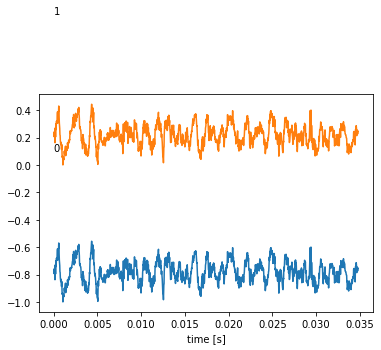

In [111]:
a1.norm().plot(offset=1).play()

In [112]:
ar.recordings.clear()
ar.recordings

[]

In [113]:
ar.quit()  # quit the recorder if is not needed - this saves CPU as the stream is closed

* To choose a different audio input or output device than the default, set input_device or output_device (which are python @properties) by assigning the integer index associated to the device. 
* Use `device_info()` to get a list of available devices, see pya helpers function. 

In [114]:
device_info()  # Function returns a string

idx Device Name              INP OUT    SR   INP-(Lo|Hi)  OUT-(Lo/Hi) (Latency in ms)
0   Built-in Microphone        2   0 44100    2.9     13    10    100
1   Built-in Output            0   2 44100     10    100   3.9     14


Alternatively, use `get_devices()` which returns two lists for inputs and outputs

In [115]:
#get_devices() returns dicts of both input and output devices. You can check their index with it. 
input_devices, output_devices = Arecorder(backend=auto_backend).get_devices()
input_devices

[{'index': 0,
  'structVersion': 2,
  'name': 'Built-in Microphone',
  'hostApi': 0,
  'maxInputChannels': 2,
  'maxOutputChannels': 0,
  'defaultLowInputLatency': 0.0029478458049886623,
  'defaultLowOutputLatency': 0.01,
  'defaultHighInputLatency': 0.01310657596371882,
  'defaultHighOutputLatency': 0.1,
  'defaultSampleRate': 44100.0}]

To change devices, simply set the property before booting

In [116]:
# Ways of switching devices
correct_input_index = input_devices[0]['index']  # The number should reflect your actual input device index. 
input_channels= input_devices[0]['maxInputChannels']
print(f'Device index is {correct_input_index}')
print(f'Input channels will be {input_channels}')

# 1. Change the device attribute
ar.device = correct_input_index
ar.boot()  # Then don't forget to reboot afterward

# 2. Use set_device(idx, reboot=True)
ar.set_device(correct_input_index)  # By default it will reboot
ar.quit()  # quit this device to release resources

# 3 Create a new Arecorder object
ar = Arecorder(device=correct_input_index, channels=input_channels, backend=auto_backend).boot()
print(ar)
ar.quit()  # quit recording server

Device index is 0
Input channels will be 2
Arecorder: sr: 44100, blocksize: 256, Stream Active: True
           Input: Built-in Microphone, Index: 0
           
